# Active Noise Cancellation - Simulation


## Introducción
La cancelación de ruido tiene distintas aplicaciones, el principio de funcionamiento de esta metodología de control es el fenómeno de interferencia destructiva y superposición lineal de onda. La idea es generar una señal idéntica a la señal de ruido que se propaga en el entorno acústico sobre el cual vamos a estar trabajando.  

Controlar y, en su caso, reducir el ruido es un reto tecnológico importante, por la complejidad temporal y espacial que presenta. La reducción del ruido implica además un considerable coste económico, por lo que en numerosas ocasiones se prefiere disminuirlo a niveles aceptables para la población que los padece, en lugar de cancelarlo completamente. Este desarrollo se va encargar de implementar los conceptos investigados para el control activo de ruido y sus funcionalidades.

Por control activo de ruido acústico (CAR) se entiende aquella técnica capaz de atenuar el ruido acústico existente en un determinado recinto, mediante la emisión de otro ruido acústico; esto es posible cuando las ondas de presión acústica de ambos ruidos están en oposición de fase. 

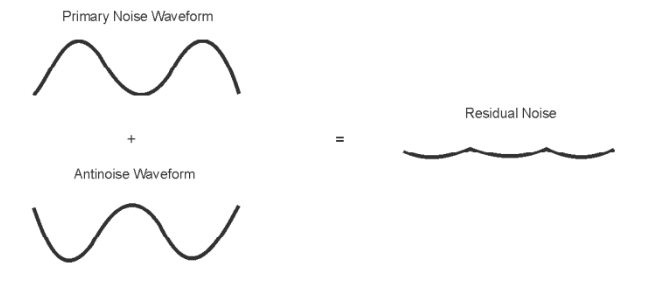

En cuanto a nuestra señal que vamos a estar utilizando en el proyecto, vamos a trabajar en profundidad con ondas acústicas, que es un fundamento principal para comprender los principios detrás de la cancelación de ruido. Varios conceptos acústicos son clave para la implementación exitosa de sonido en un contexto de sistemas de cancelación activa de ruido (ANC). 

Este sistema de control va a trabajar con las distintas procedimientos que estuvimos desarrollando a lo largo del cuatrimestre, enfoncandonos en realizar un sistema ed lazo cerrado capaz de controlar la variable de sonido mencionada anteriormente. La estructura de este sistema de control va a estar representada por el siguiente diagrama de bloques:

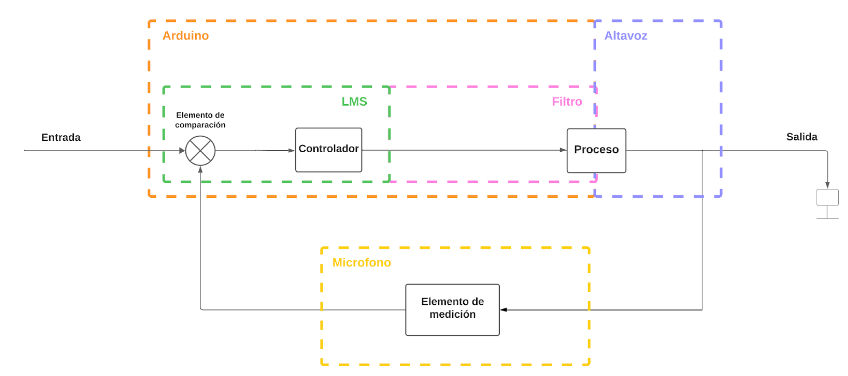

## Objetivo y alcance
Para este proyecto vamos a realizar la simulación de un sistema de control de audio para llevar a cabo la cancelación activa de ruido, este sistema de control va a poder ser aplicados en distintos ambitos. Para tener una visualización más clara de la simulación, vamos a representar un sistema de cancelación de ruido de unos auriculares con ANC incorporado. Esta simulación se basará en el diagrama de control que se visualiza anteriormente, y para realizar este desarrollo vamos a implementar los conceptos estudiados en la materia de Teoría de control, dictada por la Universidad Tecnologica Nacional.  
  
El objetivo principal va a ser lograr obtener las ondas senoidales de sonidos opuestas de distintos ruidos ambientes, estos sonidos ambientes los vamos a obtener de un dataset de acceso público.  
Al realizar este proyecto nos vamos a encontrar con ciertas limitantes que van a acotar el alcance del proyecto. A continuación se listan los puntos limitantes que dan lugar al alcance del trabajo:  
- Vamos a representar la medición como una mezcla del sonido simulado y una entrada de sonido ambiente.
- Los parametros del algoritmo LMS pueden mejorar o empeorar la cancelación de ruido. Actualmente se toman parametros determinados aptos para la simulación hecha en el contexto en el cual me encuentro trabajando.

## Implementación

### Entrada
Lo primero que vamos a realizar, va a ser generar una entrada la cual va a ser la salida esperada de nuestro sistema. Luego a esta entrada vamos a introducir las señales captadas por el microfono de sonido ambiente, que generarán ruido en nuestras ondas de sonido de entrada.  

Para generar el sonido simulado vamos a tener que definir una frecuencia, duración, frecuencia de muestreo y amplitud del sonido. Para este trabajo vamos a definir estos valores de la siguiente forma:
- La frecuencia será de 25Hz para poder visualizar limpiamente los datos en los distintos graficos
- La duración de los sonidos con los que trabajaremos será de 1 segundo.
- La frecuencia de muestreo se define según el teorema de Nyquist, donde la frecuencia máxima con la que trabajaremos será de 5000 Hz (frecuencia de audición más sensible para los humanos).
- La amplitud del sonido será de 2.

Reproducción de sonido simulado. Enter para finalizar


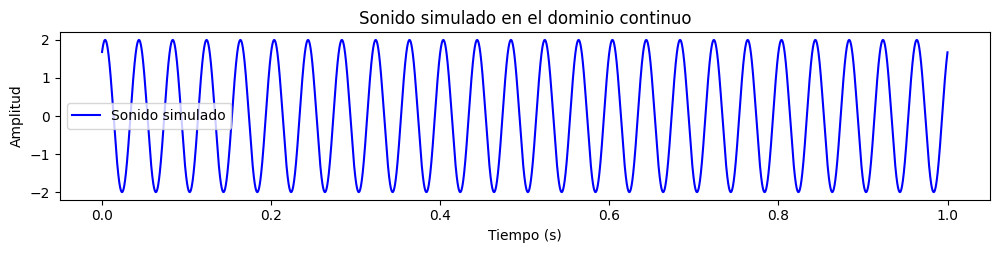

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import time
import sounddevice as sd

# Duración de reproducción para cada sonido
duracion_reproduccion = 2  # en segundos

# Configuración de la simulación
fs = 20000  # Frecuencia de muestreo en Hz. 
duration = 1  # Duración en segundos.
t_continuo = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Vector de tiempo continuo

# Parámetros del sonido constante simulado
frecuencia_simulado = 25  # Frecuencia del sonido en Hz
amplitud_simulado = 2  # Amplitud del sonido simulado
fase_simulado = 1  # Fase del sonido

# Generar sonido constante simulado
sonido_simulado = amplitud_simulado * np.sin(2 * np.pi * frecuencia_simulado * t_continuo + fase_simulado)

# Visualizar las señales de manera continua
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t_continuo, sonido_simulado, label='Sonido simulado', color='b')
plt.title('Sonido simulado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Reproducir sonido simulado
print("Reproducción de sonido simulado. Enter para finalizar")
sd.play(sonido_simulado, fs)
time.sleep(duracion_reproduccion)

La entrada si bien la mostramos en el dominio continuo, en realidad el sistema está manejandose en el tiempo discreto, ya que nos manejamos con un Array de valores que varian en amplitud.  
A continuación observaremos un gráfico con una submuestra de los valores muestreados en el dominio discreto. Utilizamos una submuestra para poder visualizar más clara la muestra obtenida.

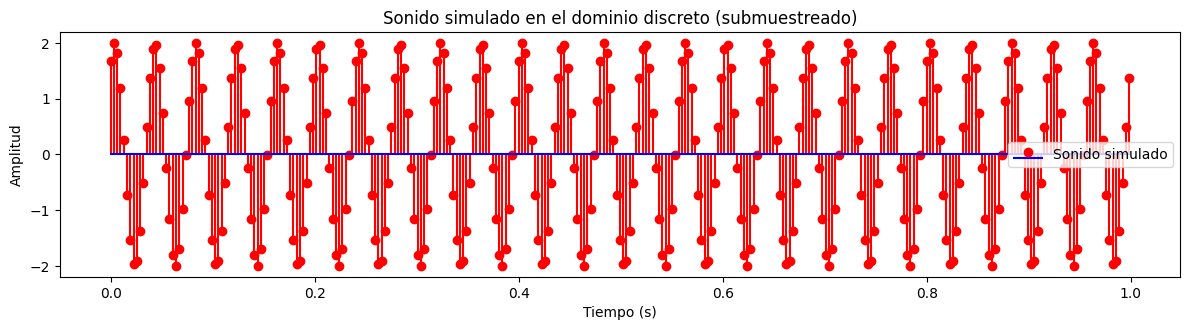

In [121]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

# Configuración del submuestreo.
submuestreo_factor = 64  # Factor de submuestreo (ajusta según sea necesario)
t_discreto = np.arange(0, duration, 1/fs)  # Vector de tiempo discreto

# Submuestrear las señales
t_discreto_submuestreado = t_discreto[::submuestreo_factor]
sonido_simulado_submuestreado = sonido_simulado[::submuestreo_factor]

# Visualizar las señales de manera discreta submuestreadas
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.stem(t_discreto_submuestreado, sonido_simulado_submuestreado, label='Sonido simulado', basefmt="b-", linefmt="r-", markerfmt="ro")
plt.title('Sonido simulado en el dominio discreto (submuestreado)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

### Medición
Para realizar un sistema de lazo cerrado va a ser fundamental tener un flujo de realimentación, a este flujo de realimentación vamos a agregar un elemento de medición que va a ser en este caso un microfono que escuche la salida de audio del sistema. Para este caso vamos a realizar una simulación de la salida general del sistema, lo que vamos a hacer va a ser obtener mediante el microfono de la computadora una muestra de sonido ambiente, que nos servirá para adicionarla a la onda senoidal simulada para simular la salida con ruido.  
  
Para realizar la muestra de sonido ambiente vamos a utilizar la biblioteca sounddevice. Una vez obtenida la muestra vamos a mezclar ambos sonidos y reproducirlos tanto analogica como graficamente.

Capturando sonido ambiente durante 1 segundos. Presiona Enter cuando hayas terminado.


Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.


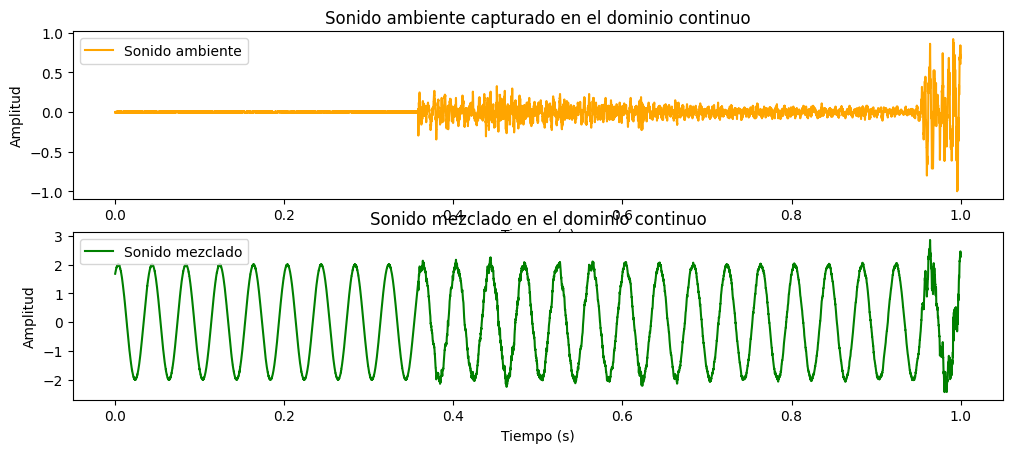

In [122]:
import sounddevice as sd

# Capturar sonido ambiente durante la duración especificada
print(f"Capturando sonido ambiente durante {duration} segundos. Presiona Enter cuando hayas terminado.")
sonido_ambiente = sd.rec(int(fs * duration), samplerate=fs, channels=1, dtype=np.float32)
input()

# Detener la grabación
sd.stop()

# Normalizar las señales
sonido_simulado /= np.max(np.abs(sonido_simulado))
sonido_ambiente[:, 0] /= np.max(np.abs(sonido_ambiente[:, 0]))

# Ajustar la amplitud del sonido simulado
sonido_simulado *= 2.0

# Mezclar las dos señales
sonido_mezclado = sonido_simulado + sonido_ambiente[:, 0]

# Reproducir sonido mezclado
print("Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.")
sd.play(sonido_mezclado, fs)

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 2)
plt.plot(t_continuo, sonido_ambiente[:, 0], label='Sonido ambiente', color='orange')
plt.title('Sonido ambiente capturado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t_continuo, sonido_mezclado, label='Sonido mezclado', color='g')
plt.title('Sonido mezclado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

Le medición realizada por el microfono se realiza mediante el uso de la biblioteca **sounddevice**, el sonido se captura en el dominio del tiempo continuo. El micrfono convierte las variaciones de presión acústica en señales eléctricas que se registran de manera continua en el tiempo.  
En resumen, convertiremos la señal acústica analógica en una señal eléctrica analógica, que luego se discretiza para crear una representación digital y poder trabajar con ella.  

Este proceso de digitalización de señales es comunmente conocido como "conversión analógico a digital", o ADC. En conclusión, el proceso de medición va a tener embebido el **ADC** que nos brindará las señales digitales con las cuales trabajaremos.  

A continuación se muestra la señal medida en el dominio discreto:

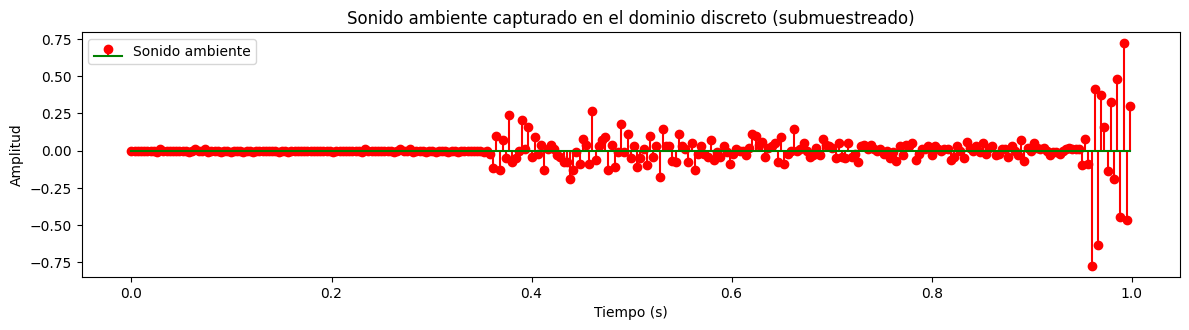

In [123]:
# Submuestrear las señales
sonido_ambiente_submuestreado = sonido_ambiente[::submuestreo_factor, 0]

# Visualizar las señales de manera discreta submuestreadas
plt.figure(figsize=(12, 6))


plt.subplot(2, 1, 2)
plt.stem(t_discreto_submuestreado, sonido_ambiente_submuestreado, label='Sonido ambiente', basefmt="g-", linefmt="r-", markerfmt="ro")
plt.title('Sonido ambiente capturado en el dominio discreto (submuestreado)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()


### Punto suma
Para el punto suma del sistema, que va a realizar la señal de error entre la entrada y la realimentación, va a ser en parte nuestro algoritmo de filtrado adaptativo "LMS".  
El algoritmo LMS es un algoritmo adaptativo que se utiliza para ajustar un filtro en tiempo real para minimizar el error cuadrático medio entre la salida deseada y la salida real del sistema. Lo vamos a utilizar para obtener un filtro que nos va a permitir obtener una señal de error, que va a ser necesaria para poder definir como realizar la cancelación de sonido.

In [124]:
import numpy as np
from scipy.signal import lfilter

# Implementar un filtro adaptativo LMS para cancelación de sonido
mu = 0.00001  # Tasa de aprendizaje del filtro LMS
order = 32  # Orden del filtro

# Inicialización del filtro LMS. Lista de parametros a aplicar.
filtro_lms = np.zeros(order)

# Aplicamos filtro LMS a la señal mezclada
for i in range(order, len(sonido_mezclado)):
    x = sonido_mezclado[i-order:i]
    y_estimado = np.dot(x, filtro_lms)
    error = sonido_simulado[i] - y_estimado
    filtro_lms = filtro_lms + mu * error * x

print("Se obtuvieron los coeficientes del algoritmo LMS.")


Se obtuvieron los coeficientes del algoritmo LMS.


### Error
A continuación se muestra la diferenciación de los errores que manejamos al comparar la señal simulada y la señal mezclada. Como podemos observar, al principio no tenemos tanto ruido el cual hay que cancelar, sin embargo, a medida que nos acercamos a 1 segundo (en el eje del tiempo), la señal de error es más grande.  
  
Para representar esto cuantitavamente vamos a tomar un submuestreo de los valores discretos obtenidos para el sonido simulado (valor entrada) y el sonido mezclado (que sería la medición).

In [125]:
import pandas as pd
from tabulate import tabulate

# Calcular el error entre sonido_simulado y sonido_mezclado
error_simulado_mezclado = sonido_simulado - sonido_mezclado

# Seleccionar 100 valores intercalados
indices_seleccionados = range(0, len(t_discreto), len(t_discreto)//100)
seleccion_acotada = {
    'Tiempo (s)': t_discreto[indices_seleccionados],
    'Sonido Simulado': sonido_simulado[indices_seleccionados],
    'Sonido Mezclado': sonido_mezclado[indices_seleccionados],
    'Error Simulado vs. Mezclado': error_simulado_mezclado[indices_seleccionados],
}

# Crear un DataFrame con los datos acotados
df_acotado = pd.DataFrame(seleccion_acotada)

# Mostrar el DataFrame en forma de tabla
tabla_acotada = tabulate(df_acotado, headers='keys', tablefmt='pretty', showindex=False)
print(tabla_acotada)

+----------------------+---------------------+---------------------+-----------------------------+
|      Tiempo (s)      |   Sonido Simulado   |   Sonido Mezclado   | Error Simulado vs. Mezclado |
+----------------------+---------------------+---------------------+-----------------------------+
|         0.0          | 1.6829474170004428  | 1.6829474170004428  |             0.0             |
|         0.01         | 1.0806081094617392  | 1.0806081094617392  |             0.0             |
|         0.02         | -1.6829474170004426 | -1.6829474170004426 |             0.0             |
| 0.030000000000000002 | -1.080608109461738  | -1.080608109461738  |             0.0             |
|         0.04         | 1.6829474170004426  | 1.6829474170004426  |             0.0             |
|         0.05         | 1.0806081094617366  | 1.0806081094617366  |             0.0             |
| 0.060000000000000005 | -1.6829474170004444 | -1.6829474170004444 |             0.0             |
|         

### Proceso
Como lo definimos en el diagrama de bloques, el proceso va a estar compuesto por dos partes funamentales:  
- Filtrado
- Altavoz

Con los coeficientes obtenidos en el algoritmo LMS, ahora procederemos a applicar el filtrado para obtener los valores del Array que conforman el sonido cancelado.

In [126]:
from scipy.signal import filtfilt

# Filtrar la señal mezclada con el filtro LMS aprendido
sonido_cancelado = filtfilt(filtro_lms, [1.0], sonido_mezclado)

### Salida
Para la salida vamos a aplicar el filtro de cancelación de ruido que obtuvimos anteriormente. Una vez hecho esto vamos a tener una nueva onda senoidal definida para el sonido cancelado, que va a ser la mezcla del sonido simulado y el sonido ambiente, pero intentando reducir al máximo posible las ondas de ruido.

Reproducción de sonido cancelado.


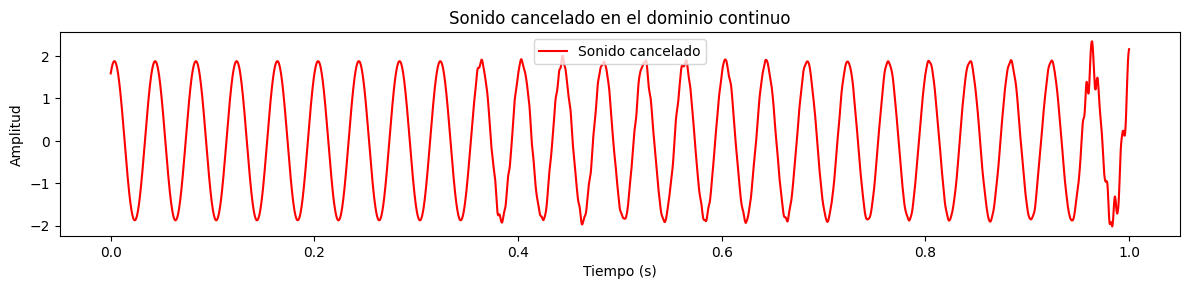

In [127]:
# Visualizar las señales de manera continua
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 4)
plt.plot(t_continuo, sonido_cancelado, label='Sonido cancelado', color='r')
plt.title('Sonido cancelado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Reproducir sonido cancelado
print("Reproducción de sonido cancelado.")
sd.play(sonido_cancelado, fs)

plt.tight_layout()
plt.show()

Finalmente vamos a mostrar en un mismo gráfico como quedaron las 3 ondas senoidales en el dominio continuo: 

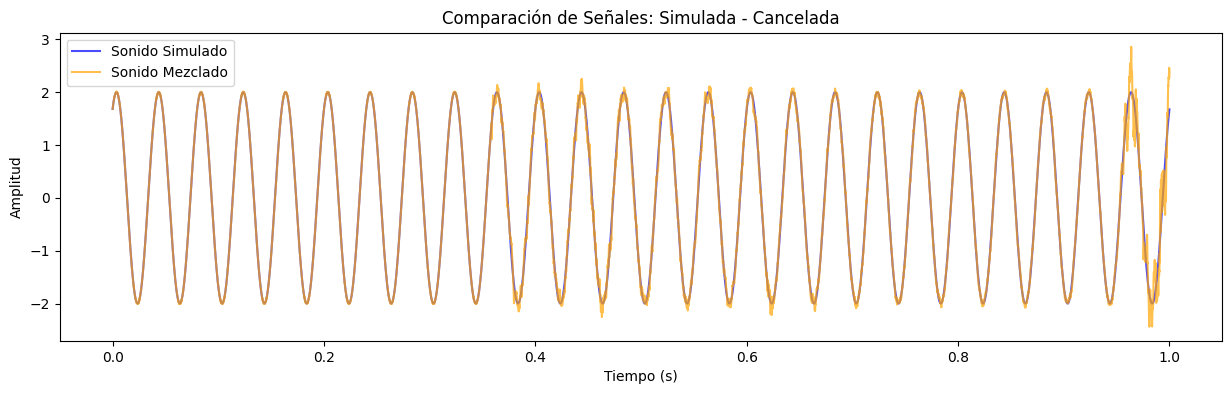

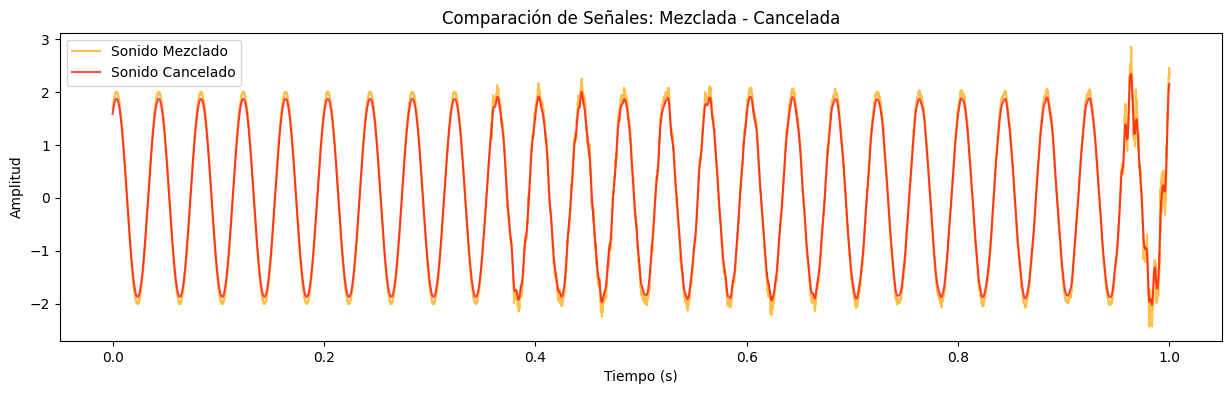

In [128]:
# Graficar la señal original y la señal mezclada
plt.figure(figsize=(15, 4))
plt.plot(t_continuo, sonido_simulado, label='Sonido Simulado', alpha=0.7, color='b')
plt.plot(t_continuo, sonido_mezclado, label='Sonido Mezclado', alpha=0.7, color='orange')
# plt.plot(t_continuo, sonido_cancelado, label='Sonido Cancelado', alpha=0.7)
plt.title('Comparación de Señales: Simulada - Cancelada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

# Graficar la señal mezclada y la señal cancelada
plt.figure(figsize=(15, 4))
plt.plot(t_continuo, sonido_mezclado, label='Sonido Mezclado', alpha=0.7, color='orange')
plt.plot(t_continuo, sonido_cancelado, label='Sonido Cancelado', alpha=0.7, color='r')
plt.title('Comparación de Señales: Mezclada - Cancelada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

In [129]:
#Reproducción del sonido simulado
sd.play(sonido_simulado, fs)

In [130]:
#Reproducción del sonido mezclado. (con ruido ambiente).
sd.play(sonido_mezclado, fs)

In [131]:
#Reproducción del sonido simulado
sd.play(sonido_cancelado, fs)

Esta salida que nosotros estamos emitiendo, lo hacemos mediante el uso de los altavoces de la computadora. Estos altavoces, en conjunto con la implementaciòn de la biblioteca **sounddevice**, conforman el proceso principal que se encargará de producir la salida obtenida luego del sistema de control.  
Incluso cabe destacar que estamos en presencia de una transformaciòn de la variable con la cual trabajamos, estamos transformando la señal perteneciente a un dominio digital, en uno analógico, lo cual significa que estamos en presencia de un **DAC** (Conversor digital-analógico), el cual está embebido dentro del altavoz. 